In [201]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# <div class="alert alert-warning"> Exploratory Data Analysis and Data Wrangling </div>

In [202]:
# Load in user data
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [203]:
# Load in user_engagement data
user_engagement = pd.read_csv('takehome_user_engagement.csv', encoding='ISO-8859-1', parse_dates=['time_stamp'])
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Clean Data

In [204]:
# Check for null values for users dataset
print('Null Values (users):')
print(users.isnull().any())

# Print newline
print('\n')

# Check for null values for user_engagement dataset
print('Null Values (user_engagement):')
print(user_engagement.isnull().any())

Null Values (users):
object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool


Null Values (user_engagement):
time_stamp    False
user_id       False
visited       False
dtype: bool


In [205]:
# Fill null values of users dataset with 0's
users = users.fillna(0)
users.isnull().any()

object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time    False
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id            False
dtype: bool

## Transform Data

#### 1.  Adopted Users (Target Value)

In [230]:
# Create function to calculate visits over 7-day rolling periods
def rolling_7D(grp):
    return grp.rolling('7D', on='time_stamp')['visited'].count()

# Only consider the first visit of each day
user_engagement = user_engagement.groupby(['user_id', pd.Grouper(key='time_stamp', freq='D')]).first().reset_index()
# Calculate 7-day rolling periods
user_engagement['rolling_visits_7d'] = user_engagement.groupby('user_id', as_index=False, group_keys=False).apply(rolling_7D)

# For each 'user_id', compile all 7-day rolling periods into a single list
adopted_users = user_engagement.groupby('user_id').agg(lambda x: x.tolist()).drop(['time_stamp','visited'], axis=1)
# Find the most number of visits of all 7-day rolling periods
adopted_users['rolling_visits_7d'] = adopted_users['rolling_visits_7d'].apply(lambda x: max(x))

# Identify 'adopted_users' 
adopted_users['adopted_user'] = adopted_users['rolling_visits_7d'].apply(lambda x: x >= 3)

# Reset index
adopted_users.reset_index(inplace=True)
# Drop 'rolling_visits_7d' column
adopted_users = adopted_users[['user_id','adopted_user']]

In [231]:
# Print adoption and churn rates
adoption_rate = adopted_users['adopted_user'].mean()
churn_rate = 1 - adoption_rate
print('Adoption Rate: {}'.format(adoption_rate))
print('   Churn rate: {}'.format(churn_rate))

Adoption Rate: 0.18157089425365522
   Churn rate: 0.8184291057463448


In [226]:
# Check if 'adopted_users' dataframe and 'users' dataframe have the same number of users
same_number_users = len(adopted_users.user_id.unique()) == len(users.object_id.unique())
print('Same Number of Users:\n {}'.format(same_number_users))

Same Number of Users:
 False


#### 2. Merge both datasets using user ids

> Because the two datasets don't have an equal amount of users, the merged dataset will have some null values in the 'adopted_user' column.
<br> 
I will correct this by performing an inner merge. This will essentially drop rows with users who did not appear in the user_engagement dataset.
</br>
<br>
I am doing this because there is no way of verifying whether they are adopted users, thus they do not aid in building the predictive model. 
</br>

In [207]:
# Merge the users data with the adopted users data
combined = pd.merge(users, adopted_users, left_on='object_id', right_on='user_id', how='inner')
# Drop 'user_id' column
combined.drop('user_id', axis=1, inplace=True)

# Check for missing values
print('Null Values:\n{}'.format(combined.isnull().any()))

combined.head()

Null Values:
object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time    False
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id            False
adopted_user                  False
dtype: bool


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


#### 3. Boolean Columns

In [208]:
# Convert 'adopted_user' column to ints
combined['adopted_user'] = combined['adopted_user'].astype(int)

# Relabel 'SIGNUP_GOOGLE_AUTH' to 'SIGNUP' in creation_source column
combined.loc[combined['creation_source'] == 'SIGNUP_GOOGLE_AUTH', 'creation_source'] = 'SIGNUP'
# Create boolean column for creation_source
dummies = pd.get_dummies(combined['creation_source'])
# Join columns to user_data DataFrame
combined = combined.join(dummies)
# Save DataFrame
combined.to_csv('combined_data.csv', index=False)

combined.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,1,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,0,1,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,0,1,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,1,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,1,0,0,0


# <div class="alert alert-warning"> Feature Selection/Building </div>

## creation_source

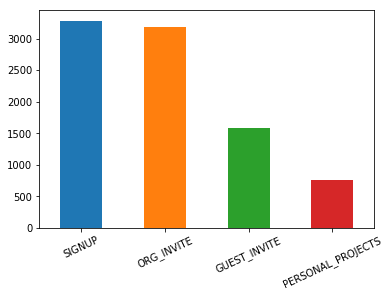

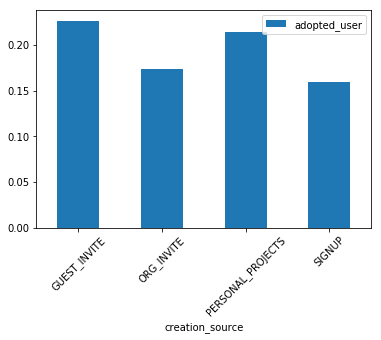

In [209]:
combined['creation_source'].value_counts().plot.bar(rot=25)
combined[['creation_source','adopted_user']].groupby('creation_source').mean().plot.bar(rot=45);

## opted_in_to_mailing_list

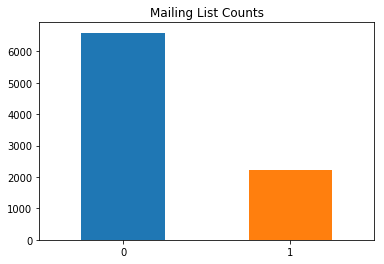

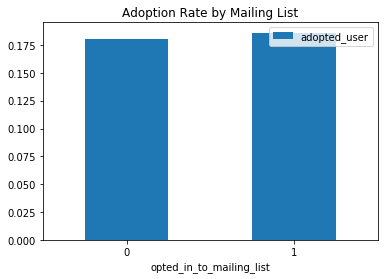

In [210]:
combined['opted_in_to_mailing_list'].value_counts().plot.bar(rot=0)
plt.title('Mailing List Counts')

combined[['opted_in_to_mailing_list','adopted_user']].groupby('opted_in_to_mailing_list').mean().plot.bar(rot=0)
plt.title('Adoption Rate by Mailing List');

## enabled_for_marketing_drip

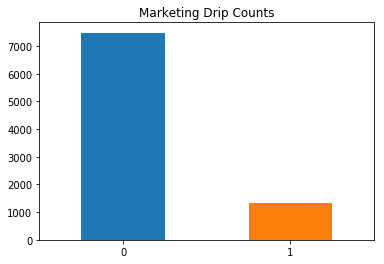

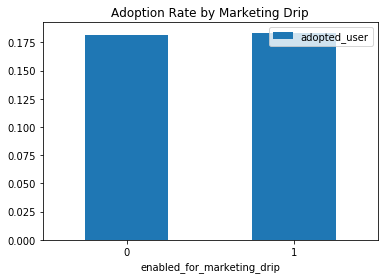

In [211]:
combined['enabled_for_marketing_drip'].value_counts().plot.bar(rot=0)
plt.title('Marketing Drip Counts')

combined[['enabled_for_marketing_drip','adopted_user']].groupby('enabled_for_marketing_drip').mean().plot.bar(rot=0)
plt.title('Adoption Rate by Marketing Drip');

## org_id

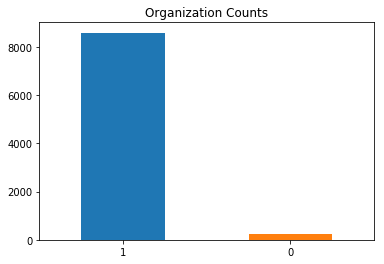

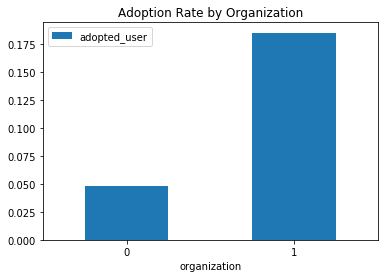

In [212]:
# Create feature column 'organization' to identify users that are part of an organization
combined['organization']= (combined['org_id'] != 0).astype(int)

combined['organization'].value_counts().plot.bar(rot=0)
plt.title('Organization Counts')

combined[['organization','adopted_user']].groupby('organization').mean().plot.bar(rot=0)
plt.title('Adoption Rate by Organization');

## invited_by_user_id

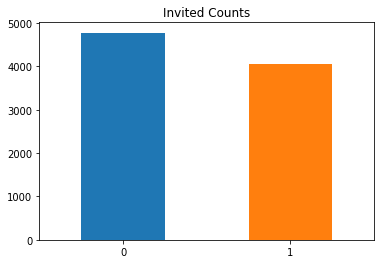

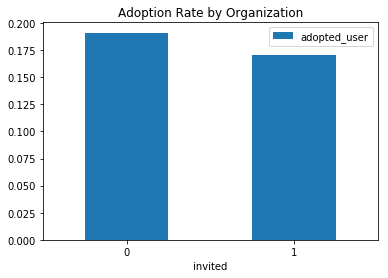

In [213]:
# Create feature column 'invited' to identify users that were invited
combined['invited']= (combined['invited_by_user_id'] == 0).astype(int)

combined['invited'].value_counts().plot.bar(rot=0)
plt.title('Invited Counts')

combined[['invited','adopted_user']].groupby('invited').mean().plot.bar(rot=0)
plt.title('Adoption Rate by Organization');

# <div class="alert alert-warning"> Modeling </div>

In [214]:
# Define unnecessary columns
drop_list = ['object_id', 'creation_time', 'name', 'email',
             'creation_source', 'last_session_creation_time',
             'adopted_user']

# Define feature columns
features = combined.drop(drop_list, axis=1).columns

# Split feature data and target data
X = combined[features]
y = combined['adopted_user']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Standardize the features
temp = StandardScaler().fit(X_train)
X_train_scaled = temp.transform(X_train)
X_test_scaled = temp.transform(X_test)

## Random Forest Tree Classifier

Training Accuracy: 0.9203740436384245
Test Accuracy: 0.7654390934844193
AUC Score is: 0.5485542973009956 


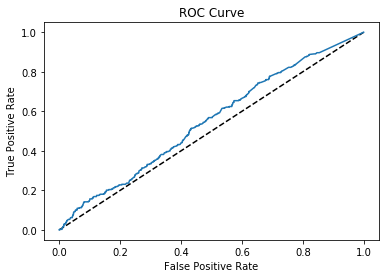

In [215]:
# Set up RandomForestClassifier and fit to data
clf = RandomForestClassifier(n_estimators=101,random_state=42)
clf.fit(X_train_scaled, y_train)

# Make predictions
predictions = clf.predict(X_train_scaled)

# Print score
print('Training Accuracy:', clf.score(X_train_scaled, y_train))
print('Test Accuracy:', clf.score(X_test_scaled, y_test))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test_scaled)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Print AUC Score
print("AUC Score is: {} ".format(roc_auc_score(y_test, y_pred_prob)))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig('images/roc_curve');

In [216]:
# Create confusion matrix
conf_mat = confusion_matrix(y_test, clf.predict(X_test_scaled))
# Print confusion matrix
print('Confusion Matrix: \n{}\n'.format(conf_mat))

# Isolate true/false pos/neg
true_pos = conf_mat[1,1]
false_pos = conf_mat[1,0]
true_neg = conf_mat[0,0]
false_neg = conf_mat[0,1]

# Calculate rates
true_pos_rate = true_pos/(true_pos+false_neg)
true_neg_rate = true_neg/(true_neg+false_pos)
# Print rates
print('True Pos Rate: {}'.format(true_pos_rate))
print('True Neg Rate: {}'.format(true_neg_rate))

Confusion Matrix: 
[[1303  124]
 [ 290   48]]

True Pos Rate: 0.27906976744186046
True Neg Rate: 0.8179535467671061


,importance,labels
2,0.606466,org_id
3,0.353562,invited_by_user_id
0,0.013744,opted_in_to_mailing_list
1,0.011480,enabled_for_marketing_drip
4,0.003805,GUEST_INVITE
5,0.003201,ORG_INVITE
8,0.002525,organization
7,0.002121,SIGNUP
6,0.001942,PERSONAL_PROJECTS
9,0.001155,invited


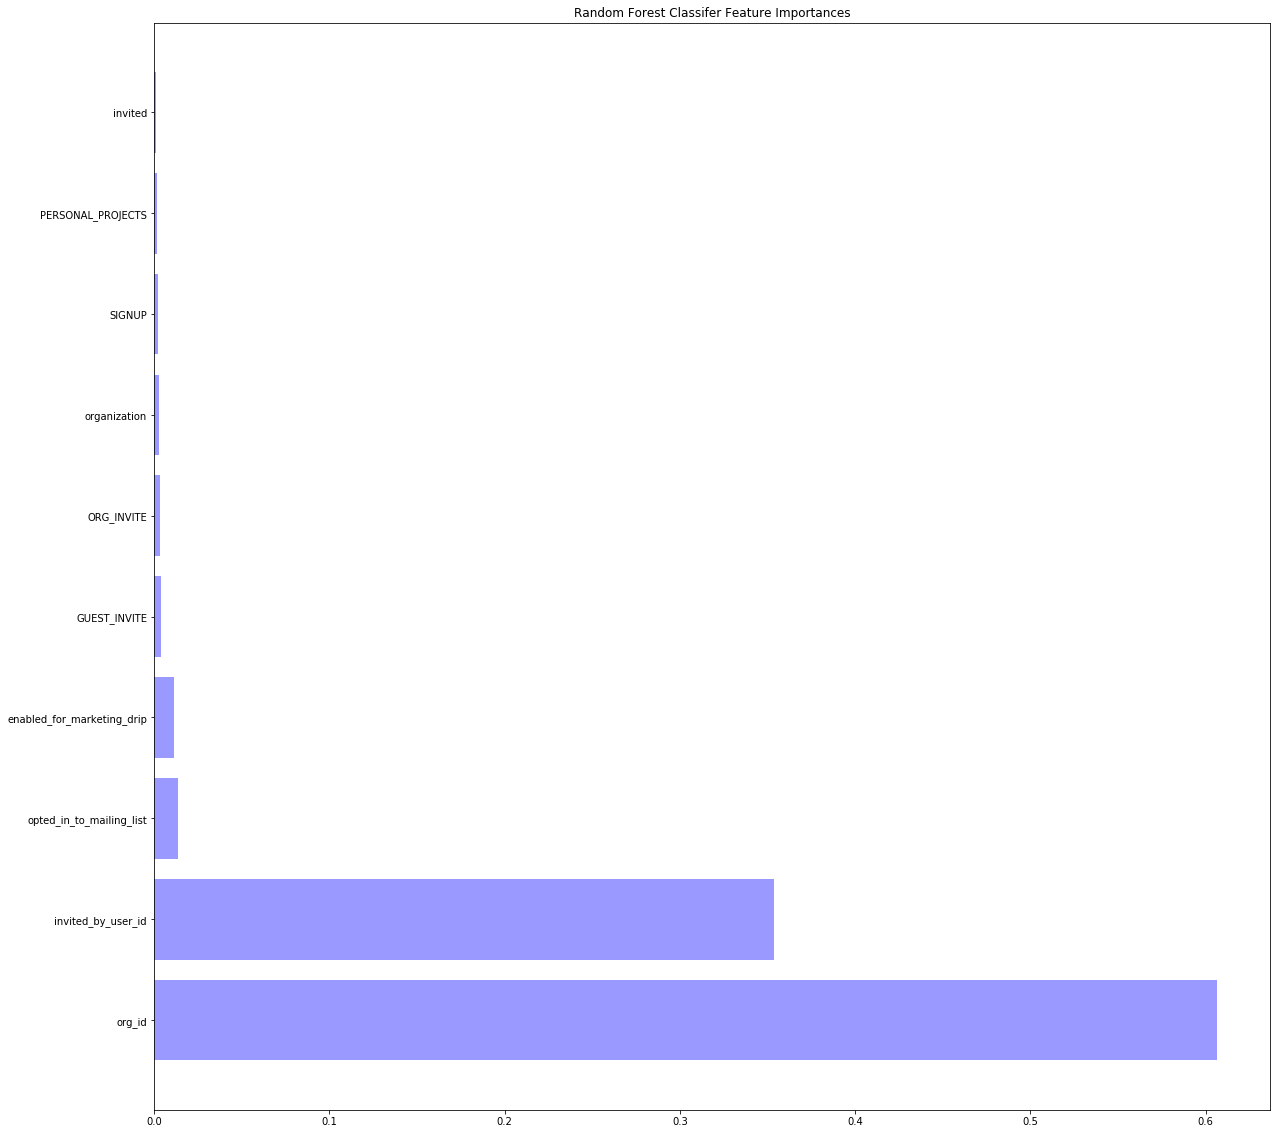

In [233]:
# Create DataFrame to store feature importances of the model
feature_importances = pd.DataFrame(clf.feature_importances_, columns=["importance"])
# Properly label each feature
feature_importances['labels'] = features
# Sort the features by importance in descending order
feature_importances.sort_values("importance", inplace=True, ascending=False)
# Display the features
display(feature_importances)

# Create plot
plt.figure(figsize=(20,20))
# Set x_range
x_range = np.arange(len(clf.feature_importances_))
# Plot the feature importances
feature_importance_chart = plt.barh(x_range , feature_importances['importance'], alpha=0.4, color='b', label='Main')
# Set y_ticks
plt.yticks(x_range, feature_importances['labels'])
plt.title('Random Forest Classifer Feature Importances')

# Save plot
plt.savefig('images/rfc_feature_importance_chart');

## Logistic Regression Classifier

In [ ]:
# Set parameter grid
param_grid = {'C':np.logspace(-5, 8, 15),
              'penalty' : ['l1', 'l2']}
rfc_cv = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5)
rfc_cv.fit(X, y)
print('Best parameters:', rfc_cv.best_params_)
print('Best score:', rfc_cv.best_score_)

Training Accuracy: 0.8209124397846416
Test Accuracy: 0.8084985835694051
AUC Score is: 0.6028236089284011 


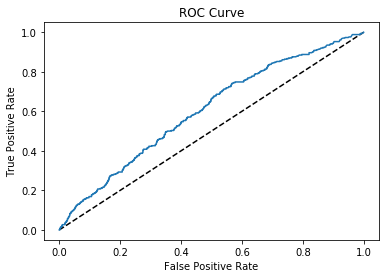

In [234]:
# Set up LogisticRegression Classifier and fit to data
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

# Make predictions
predictions = logreg.predict(X_train_scaled)

# Print score
print('Training Accuracy:', logreg.score(X_train_scaled, y_train))
print('Test Accuracy:', logreg.score(X_test_scaled, y_test))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Print AUC Score
print("AUC Score is: {} ".format(roc_auc_score(y_test, y_pred_prob)))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig('images/logreg_roc_curve');

In [219]:
# Create confusion matrix
conf_mat = confusion_matrix(y_test, clf.predict(X_test_scaled))
# Print confusion matrix
print('Confusion Matrix: \n{}\n'.format(conf_mat))

# Isolate true/false pos/neg
true_pos = conf_mat[1,1]
false_pos = conf_mat[0,1]
true_neg = conf_mat[0,0]
false_neg = conf_mat[1,0]

# Calculate rates
true_pos_rate = true_pos/(true_pos+false_neg)
true_neg_rate = true_neg/(true_neg+false_pos)
# Print rates
print('True Pos Rate: {}'.format(true_pos_rate))
print('True Neg Rate: {}'.format(true_neg_rate))

Confusion Matrix: 
[[1303  124]
 [ 290   48]]

True Pos Rate: 0.14201183431952663
True Neg Rate: 0.913104414856342


,importance,labels
8,0.240888,organization
2,0.143579,org_id
4,0.074220,GUEST_INVITE
6,0.057764,PERSONAL_PROJECTS
3,0.039734,invited_by_user_id
0,0.032080,opted_in_to_mailing_list
1,0.019208,enabled_for_marketing_drip
9,-0.017647,invited
5,-0.041294,ORG_INVITE
7,-0.052188,SIGNUP


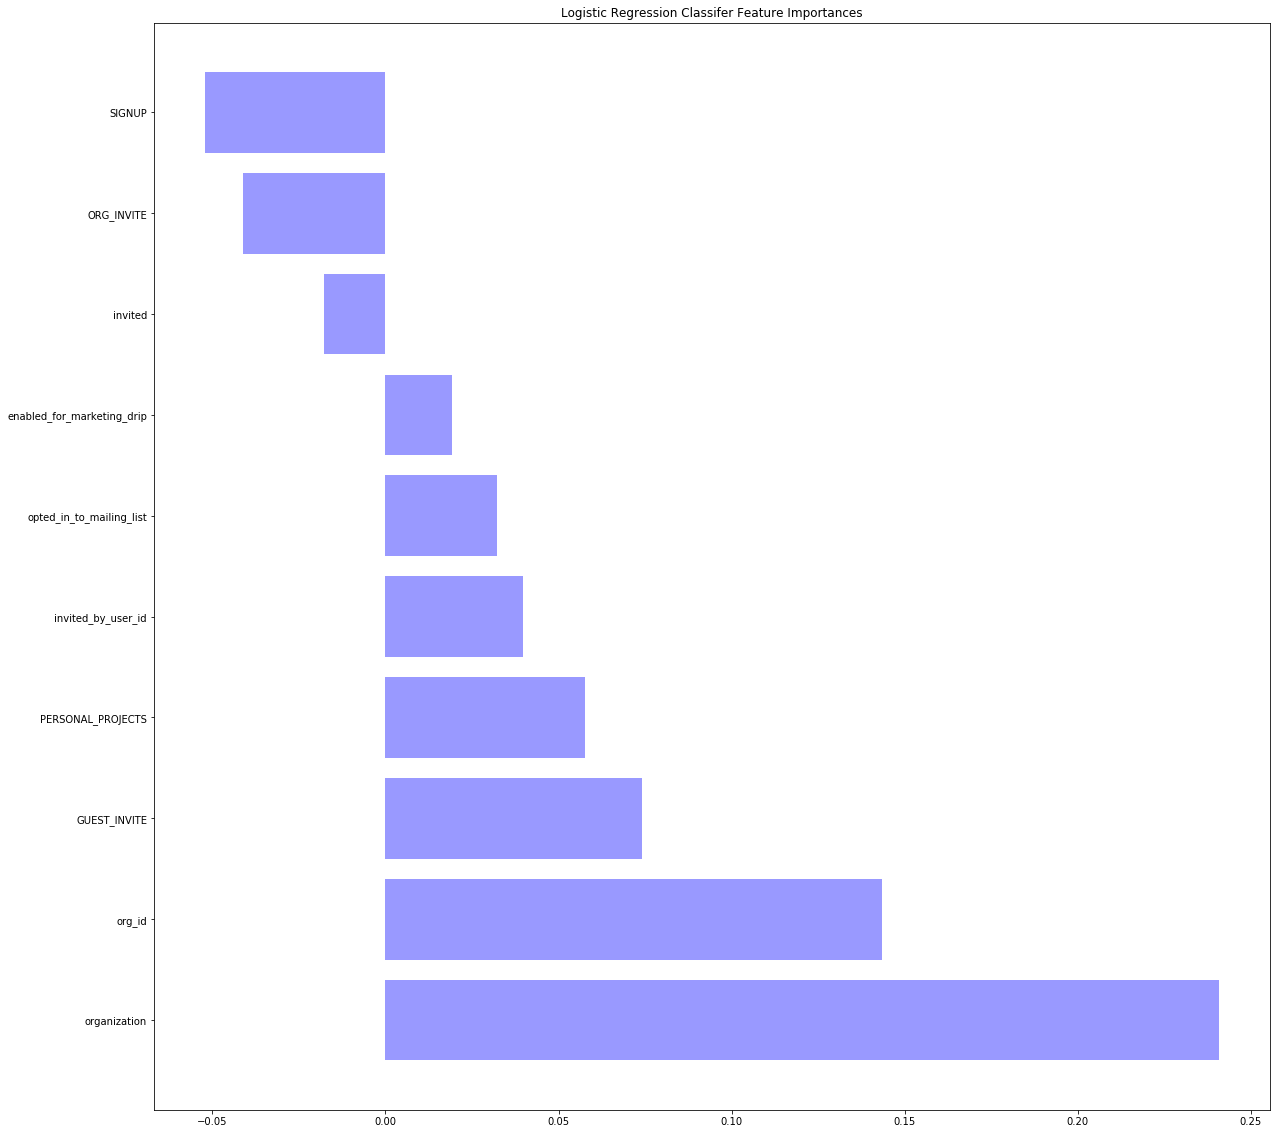

In [235]:
# Create DataFrame to store feature importances of the model
feature_importances = pd.DataFrame(logreg.coef_.flatten(), columns=["importance"])
# Properly label each feature
feature_importances['labels'] = features
# Sort the features by importance in descending order
feature_importances.sort_values("importance", inplace=True, ascending=False)
# Display the features
display(feature_importances)

# Create plot
plt.figure(figsize=(20,20))
# Set x_range
x_range = np.arange(len(clf.feature_importances_))
# Plot the feature importances
feature_importance_chart = plt.barh(x_range , feature_importances['importance'], alpha=0.4, color='b', label='Main')
# Set y_ticks
plt.yticks(x_range, feature_importances['labels'])
plt.title('Logistic Regression Classifer Feature Importances')

# Save plot
plt.savefig('images/logreg_feature_importance_chart');

# <div class="alert alert-warning"> Conclusion </div>

### Adopted Rates
'Relax' defines an adopted user as one has logged into the product on at least three separate days in at least one seven-day period, so I accessed the user_engagement dataset to aggregate the logins in 7-day rolling periods.
<br>
I then identifed users who logged in at least 3 times in at least one 7-day rolling period, as an adopted user.
</br>

The adoption and churn rates are as follows
<br> **Adoption rate:** 0.18157089425365522 </br>
<br> **Churn rate:** 0.8184291057463448 </br>

Of the two models I created, the Random Forest Classifier performed the best, with the following metrics:
<br> **Training Accuracy:** 0.8209124397846416 </br>
<br> **Test Accuracy:** 0.8084985835694051 </br>
<br> **AUC Score is:** 0.6028236089284011  </br>
<img src="images\logreg_roc_curve.png">
<br> **Confusion Matrix:** </br> 
<br> [[1303  124] </br> 
<br>  [ 290   48]] </br> 
<br> <br> </br> </br>
<br> **True Positive Rate:** 0.14201183431952663 </br>
<br> **True Negative Rate:** 0.913104414856342 </br>
<img src="images/logreg_feature_importance_chart.png">

The model's test accuracy is quite good, at 80.85%, but has a very low AUC score.
<br>
As you can see, it does a terrible job of predicticting adoption rates, which I believe is due to the fact that the dataset contains such a low amount of adopted users, but it does a great job of predicting churn rates.
</br>
<br>
The model isn't perfect, but does an amazing job of predicting churn rates (**True Negative Rate:** 0.913104414856342).
</br>

I think the model can be improved if Relax increased their data collection process to include much more user engagement to improve the number of adopted users in the dataset.